# AB Test
> An **A/B test is a controlled experiment** used to compare two versions of something (e.g., a website button, email subject line, or pricing page) to see which performs better on a key business metric such as conversion rate.
> It is typically constructed with a hypothesis in mind. For example, that price B produces higher profit than price A.

* Users are randomly split into two groups: **Group A** (the control, current version) and **Group B** (the variant, new version).
* By comparing the outcomes (e.g., % of users who convert) between groups, we **estimate the uplift** (the difference in performance).
* Because results are based on a sample, we account for uncertainty using statistics:
  * we calculate a **p-value** (to test if the observed difference is likely real or just random noise)
  * and a **confidence interval** (to show the plausible range of the true uplift).
  * If the effect is both statistically significant and business meaningful, we can roll out the new variant with confidence.

## Step 1 — Frame the question

**Approach**:
* **Primary metric** (north star): e.g., conversion rate (CR).
* **Hypotheses**:
  * $H_0: p_B \le p_A$(no uplift)
  * $H_1: p_B > p_A$ (positive uplift)
* **Minimum Detectable Effect** (MDE): e.g., +2 percentage points.
* **Significance** $\alpha$ and **Power** $1-\beta$: e.g., $\alpha=0.05, power =0.8.$
* **Tail**: one-tailed if you’ll only ship a win (B>A). Two-tailed if any difference matters.
* **Unit of randomization**: user, session, etc. (stickiness matters!).
* **Guardrails**: e.g., bounce, latency, gross revenue impact.

**Outcome**: A clear pass/fail rule before you see data.


## Step 2 — Plan sample size (before the test)
**Goal**: Ensure enough traffic to detect your MDE with chosen $\alpha, \text{power}$.

**Approach**: Two-proportion power calc. This simplified formula in the code is common and OK for back-of-envelope. If you want the classical formula, use:

$$n_{\text{per group}} \;=\;
\frac{\Big( z_{1-\alpha^*}\,\sqrt{2\bar p (1-\bar p)} \;+\; z_{1-\beta}\,\sqrt{p_A(1-p_A)+p_B(1-p_B)} \Big)^2 }
{(p_B - p_A)^2}$$

where:
* $p_A$ = baseline_rate,
* $p_B$ = $p_A + \Delta$ (expected treatment rate given the MDE),
* $\bar p$ = $(p_A + p_B)/2$
* $z_{1-\alpha}$ = z-value for significance
* $z_{1-\beta}$ = z-value for desired power
* For a **one-tailed test**, all of α sits in one tail, so:
  * $\alpha^* = \alpha \quad \Rightarrow \quad z_{1-\alpha^*} = z_{1-\alpha}$
* For a **two-tailed test**, α is split between the two tails, so:
  * $\alpha^* = \tfrac{\alpha}{2} \quad \Rightarrow \quad z_{1-\alpha^*} = z_{1-\alpha/2}$

**Sample size grows when**:
* the MDE (Δ) is smaller (harder to detect → need more people),
* baseline rate moves toward 50% (variance p(1−p) is largest at 0.5),
* you want higher power or lower alpha (stricter tests → more people).

## Step 3 — Randomize & run (implementation checklist)

**Goal**: Assign users 50/50 to A/B and log outcomes.

**Approach checklist**:
* **Deterministic bucketing** (e.g., hash(user_id) mod 100 < 50 → A).
* **Sticky assignment** per user across sessions/devices.
* **Single exposure** to one variant.
* **Clean logging**: user_id, variant, converted (0/1), timestamp.

**Outcome**: Clean experiment data.

## Step 4 — Sanity checks (pre-analysis)
**Goal**: Make sure the experiment ran correctly.

**Approach**:
* Balance: Is traffic roughly 50/50?
* Pre-exposure metrics: Similar across arms (if applicable).
* Data quality: No duplicate users across arms, timestamps in range.

**Outcome**: Confidence that results aren’t biased by implementation.

## Step 5 — Analyze primary effect
**Goal**: Estimate uplift, uncertainty, and a p-value that matches your hypothesis.

1. **Uplift (Effect Size)**
* The difference in conversion rates between Variant B and Control A.
* Example:
  * A = 6% conversion
  * B = 8% conversion
  * Uplift = 8% – 6% = +2 percentage points (pp)
* **Business meaning**: “If we ship Variant B, we expect 2 more customers per 100 will convert.”

2. **Uncertainty** (Standard Error & Confidence Interval)
* Because we only observe a **sample** of users, there’s randomness.
* The **Standard Error (SE)** measures how much the estimate might wiggle just by chance.
* The **Confidence Interval (CI)** gives a range of plausible values for the true uplift.
* Example: 95% CI = [+0.5 pp, +3.5 pp].
* **Business meaning**: Even in the worst case (+0.5%), B still beats A.

3. P-value
* The p-value answers:
  * *"If there were really no uplift at all (H₀ true), how likely is it to observe results at least this extreme just by random chance?"*
* Example:
  * p-value = 0.03 → only 3% chance random noise explains this result.
  * If p < α (e.g., 0.05), we say the result is statistically significant.
* Important clarification:
  * The p-value is not the probability that H₀ is true.
  * It’s the probability of seeing your data (or more extreme) given H₀ is true.
* Business translation:
  * If uplift is positive and p < α and CI doesn’t cross 0 → we can confidently say Variant B outperforms A.


**Approach**:
* Point estimate: $\hat p_A, \hat p_B, \widehat{\Delta}=\hat p_B-\hat p_A$.
* Standard Error (SE):
  * For hypothesis test, classical z-test uses pooled SE under H_0:
  * $\hat p = \frac{x_A+x_B}{n_A+n_B}, \quad
SE_{pooled}=\sqrt{\hat p (1-\hat p)\Big(\frac1{n_A}+\frac1{n_B}\Big)}$
  * For confidence interval, many use unpooled (Wald) SE:
  * $SE_{unpooled}=\sqrt{\frac{\hat p_A(1-\hat p_A)}{n_A}+\frac{\hat p_B(1-\hat p_B)}{n_B}}$
  * (Newcombe/Wilson intervals are often better, but Wald is OK for teaching.)


### Terminology Cheat Sheet
| Concept         | What it measures                          | Example (A=6%, B=8%)            | Business meaning                              |
|-----------------|-------------------------------------------|----------------------------------|-----------------------------------------------|
| Uplift          | Difference in conversion rates (B - A)    | +2 percentage points (pp)        | If we ship B, ~2 more customers per 100 convert |
| Uncertainty (SE)| How much results wiggle by chance         | ±0.7 pp (standard error)         | Our estimate could vary by ~0.7 pp randomly    |
| Confidence Int. | Plausible range for true uplift           | [ +0.5 pp, +3.5 pp ]             | Worst case: +0.5 pp, Best case: +3.5 pp       |
| P-value         | Probability of seeing this (or more) extreme result if no effect exists | 0.03 (3%) | Only 3% chance this result is pure luck → strong evidence B > A |

## Step 6 — Guardrails & diagnostics

**Goal**: Ensure you didn’t “win the battle but lose the war”.

**Approach**:
* **Check guardrail metrics** (e.g., page speed, bounce, support tickets).
* **False discovery control** if you ran multiple simultaneous tests.
* **Peeking caution**: Avoid early stopping without alpha-spending or sequential methods.

**Outcome**: Safe rollout decision.

## Step 7 — Segment carefully (optional)

**Goal**: Understand for whom it works (without p-hacking).

**Approach**:
* Pre-register a few **segments** (device, country, new vs returning).
* Adjust for multiple comparisons (e.g., Benjamini–Hochberg).
* Treat segments as exploratory unless pre-specified.

**Outcome**: Insights to inform targeting; avoid over-interpretation.

## Step 8 — Decision & rollout
**Goal**: Translate stats into action.

**Approach**:
* If significant uplift + guardrails OK → ship B.
* If borderline, consider longer run or higher MDE next time.
* Document learning for future tests.

**Outcome**: Business decision with rationale and evidence.


In [ ]:
import numpy as np
from scipy.stats import norm

# ============================================================
# A/B TEST — END-TO-END EXAMPLE (TEACHING-ORIENTED VERSION)
# ============================================================

# --------------------------
# 0) INPUTS: Decide BEFORE the test
# --------------------------
# Business inputs (PRIMARY METRIC = conversion rate)
baseline_rate = 0.06        # p_A:  expected conversion rate in the control (A). E.g., 6% of users in A convert.
mde           = 0.02        # Minimum Detectable Effect (absolute uplift in points). How much more conversion rate in B vs A you care about detecting.
                            # 0.02 means you want to reliably detect B=8% vs A=6% (a +2 percentage-point uplift).
alpha         = 0.05        # Significance level. Type I error: Probability of a false positive
                            # (declaring B > A when it isn’t). 0.05 is common (5%).
power         = 0.80        # Desired statistical power (1 - beta). probability to detect the effect if it truly exists.
                            # 0.80 means you want an 80% chance to detect the MDE.
one_tailed    = True        # If you only ship on B>A, use one-tailed; else set to False.
                            # If True, you only care whether B > A (one-sided test).
                            # If False, you care whether B ≠ A (two-sided).
                            # One-tailed needs a smaller sample for the same α because the rejection region is all on one side.

# (Optional) Reproducibility for the demo simulation below
rng = np.random.default_rng(42)

# --------------------------
# 1) HYPOTHESES (document them!)
# --------------------------
# H0: p_B <= p_A         (no positive uplift)
# H1: p_B >  p_A         (positive uplift)
# If two-tailed, H1 would be p_B != p_A.

# --------------------------
# 2) SAMPLE SIZE (classical two-proportion calculation)
# --------------------------
# Why this formula?
# - It targets your chosen alpha, power, and MDE.
# - Uses an average rate for the variance under the alternative.
# Notes:
# - If you choose two-tailed, z_alpha should use alpha/2.
# - This is the "classical" approximation widely used in practice.

pA = baseline_rate                 # Expected conversion rate in control group (A)
pB = baseline_rate + mde           # Expected conversion rate in variant group (B), 
                                   # assuming the minimum detectable effect (MDE) happens

pbar = (pA + pB) / 2.0             # Average of pA and pB → used to estimate variance under H1 
                                   # (alternative hypothesis, when effect exists)

# Critical values for significance and power:
z_alpha = norm.ppf(1 - (alpha if one_tailed else alpha/2))  
# z_alpha = z-score threshold corresponding to your chosen alpha (significance level)
# Example: for alpha=0.05 one-tailed → z_alpha ≈ 1.645
#           for alpha=0.05 two-tailed → z_alpha ≈ 1.96

z_beta  = norm.ppf(power)          
# z_beta = z-score threshold corresponding to desired power (1 - beta)
# Example: for power=0.8 → z_beta ≈ 0.84

# Numerator/denominator of the closed-form sample size per arm:
num = (z_alpha * np.sqrt(2 * pbar * (1 - pbar)) +
       z_beta  * np.sqrt(pA * (1 - pA) + pB * (1 - pB))) ** 2

den = (pB - pA) ** 2               # Squared effect size (difference between B and A)

n_per_group = int(np.ceil(num / den))  
# Required sample size per group (A and B) so that the test has 
# the desired alpha and power for detecting the MDE

# --------------------------
# 3) RUN THE TEST (real life = log real data; here we simulate)
# --------------------------
# In production:
# - Randomize users 50/50 to A/B with sticky assignment
# - Log user_id, variant, converted(0/1), timestamp
# Here we simulate binomial outcomes at the planned sample size.
n_A = n_per_group
n_B = n_per_group

# Simulate observed conversions (replace with real counts in practice)
x_A = rng.binomial(n_A, pA)   # number of conversions in control
x_B = rng.binomial(n_B, pB)   # number of conversions in treatment

# Observed conversion rates
phat_A = x_A / n_A
phat_B = x_B / n_B
uplift = phat_B - phat_A      # observed absolute difference (B - A)

# --------------------------
# 4) ANALYSIS
# --------------------------

# A) Hypothesis Test (pooled SE under H0)
#    - Classical two-proportion z-test uses the pooled estimate under H0

p_pool = (x_A + x_B) / (n_A + n_B)  
# Pooled conversion rate across A and B (assuming H0 is true, i.e. no difference)
# This is our best estimate of the "true" conversion rate if both groups are the same.

SE_pooled = np.sqrt(p_pool * (1 - p_pool) * (1/n_A + 1/n_B))  
# Standard Error under H0 (pooled) → measures expected random fluctuation of the difference
# Smaller SE → more precise estimate; larger SE → more uncertainty.

# Edge case: if SE_pooled=0 (extremely rare in practice with large n), bail out
if SE_pooled == 0:
    z_stat = np.nan
    p_value = np.nan
else:
    z_stat = uplift / SE_pooled  
    # The z-statistic (test statistic): how many SEs away the observed uplift is from 0
    # z > 0 means B is better than A, magnitude tells us "signal-to-noise ratio".

    if one_tailed:
        # One-tailed test: probability of seeing this or larger z if H0 is true
        p_value = 1 - norm.cdf(z_stat)
    else:
        # Two-tailed test: probability of seeing this extreme difference (positive or negative)
        p_value = 2 * (1 - norm.cdf(abs(z_stat)))


# B) Confidence Interval (unpooled/Wald; easy to teach)
#    - Uses separate variances for A and B (unpooled).
#    - Shows a plausible range for the true uplift.

SE_unpooled = np.sqrt(phat_A*(1-phat_A)/n_A + phat_B*(1-phat_B)/n_B)  
# Standard Error under H1 (unpooled) → accounts for A and B separately.
# Used for confidence intervals, because under H1 we don’t assume equal rates.

z_crit_95 = norm.ppf(0.975)   # Critical z-value for 95% CI (≈ 1.96, two-tailed)

ci_lower = uplift - z_crit_95 * SE_unpooled  
ci_upper = uplift + z_crit_95 * SE_unpooled  
# Confidence interval for the uplift: the range of plausible true effects
# If the CI excludes 0 → evidence that B really differs from A

# --------------------------
# 5) REPORT RESULTS
# --------------------------
results = {
    "Inputs": {
        "baseline_rate (p_A)": baseline_rate,
        "MDE (absolute)": mde,
        "alpha": alpha,
        "power": power,
        "one_tailed": one_tailed
    },
    "Planned Sample Size": {
        "n_per_group": n_per_group,
        "total_n": n_per_group * 2
    },
    "Observed": {
        "x_A (conversions)": int(x_A),
        "n_A": n_A,
        "p_A": round(phat_A, 4),
        "x_B (conversions)": int(x_B),
        "n_B": n_B,
        "p_B": round(phat_B, 4),
        "uplift (B - A)": round(uplift, 4)
    },
    "Test": {
        "z_stat (pooled)": round(z_stat, 3) if SE_pooled != 0 else None,
        "p_value": round(p_value, 4) if SE_pooled != 0 else None,
        "significant?": (p_value < alpha) if SE_pooled != 0 else None,
        "95% CI for uplift (unpooled)": [round(ci_lower, 4), round(ci_upper, 4)]
    }
}

for k, v in results.items():
    print(f"{k}: {v}")

# --------------------------
# 6) OPTIONAL GUIDANCE / NEXT STEPS
# --------------------------
# - Guardrails: Check bounce rate, latency, revenue impact, etc.
# - Peeking: Avoid early stopping unless you use sequential methods (alpha-spending).
# - Segments: If you slice results (device/country), control for multiple testing (e.g., BH-FDR).
# - If p is borderline, consider longer run or adjust MDE next time.
# - Document learning; feed into your experiment backlog and roadmap.

Inputs: {'baseline_rate (p_A)': 0.06, 'MDE (absolute)': 0.02, 'alpha': 0.05, 'power': 0.8, 'one_tailed': True}
Planned Sample Size: {'n_per_group': 2012, 'total_n': 4024}
Observed: {'x_A (conversions)': 124, 'n_A': 2012, 'p_A': 0.0616, 'x_B (conversions)': 143, 'n_B': 2012, 'p_B': 0.0711, 'uplift (B - A)': 0.0094}
Test: {'z_stat (pooled)': np.float64(1.203), 'p_value': np.float64(0.1144), 'significant?': np.False_, '95% CI for uplift (unpooled)': [np.float64(-0.0059), np.float64(0.0248)]}


## A/B Test visualization
* **Blue bar** = Control (A) conversion rate
* **Red bar** = Variant (B) conversion rate
* **Error bars** = statistical uncertainty (Standard Error)
* **Annotation** = observed uplift and its 95% Confidence Interval

**How to read it:**
* **Uplift** = +2 pp → B outperforms A.
* **Confidence Interval (CI)** = [+0.5 pp, +3.5 pp] → The true uplift is very likely within this range.
* **Because the CI is fully above 0 → the uplift is statistically significant.**

**Together:**
* **Uplift** = what we observed
* **P-value** = chance result is random noise (small → good evidence)
* **CI** = business context (“what’s the best/worst plausible uplift if we ship B?”)

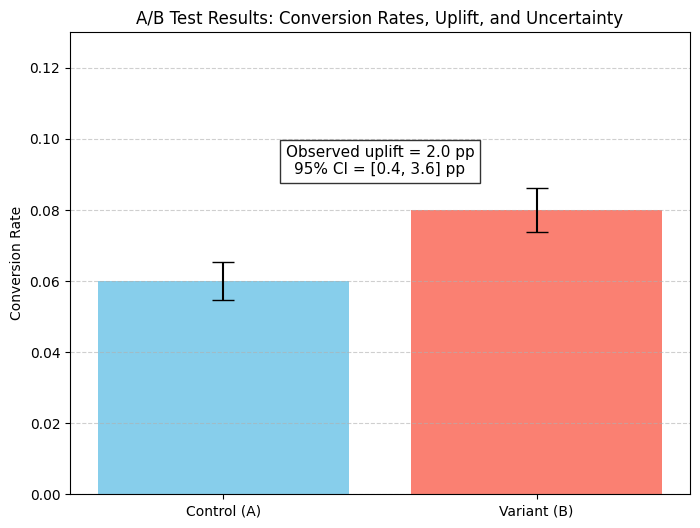

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Example numbers (A/B test)
p_A = 0.06     # Control conversion rate
p_B = 0.08     # Variant conversion rate
n_A = n_B = 2000

uplift = p_B - p_A

# Standard errors
SE_A = np.sqrt(p_A*(1-p_A)/n_A)
SE_B = np.sqrt(p_B*(1-p_B)/n_B)
SE_diff = np.sqrt(SE_A**2 + SE_B**2)

# 95% CI for uplift
z_crit = norm.ppf(0.975)
ci_lower = uplift - z_crit*SE_diff
ci_upper = uplift + z_crit*SE_diff

# --------------------
# Visualization
# --------------------
plt.figure(figsize=(8,6))
groups = ['Control (A)', 'Variant (B)']
rates = [p_A, p_B]
errors = [SE_A, SE_B]

# Conversion rates with error bars
plt.bar(groups, rates, yerr=errors, capsize=8, color=['skyblue','salmon'])
plt.ylabel("Conversion Rate")
plt.title("A/B Test Results: Conversion Rates, Uplift, and Uncertainty")

# Annotate uplift and CI range
plt.text(0.5, max(rates)+0.01, 
         f"Observed uplift = {uplift*100:.1f} pp\n95% CI = [{ci_lower*100:.1f}, {ci_upper*100:.1f}] pp",
         ha='center', fontsize=11, bbox=dict(facecolor='white', alpha=0.8))

plt.ylim(0, max(rates)+0.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## Visual explanation of the P-Value

* The **black curve** = the null distribution (what z-scores look like if there is no uplift).
* The **blue dotted line** = critical value (z = 1.645 for α=0.05, one-tailed).
* The **blue shaded area** = rejection region (if observed z falls here, we reject H₀).
* The **red dashed line** = your observed test statistic (z ≈ 2.44).
* The **red shaded area** = the p-value — the probability of seeing a result at least this extreme if H₀ were true.

**Teaching takeaway:**
* If the **red shaded p-value** area is smaller than α (5%), → statistically significant.
* P-value tells us how surprising our result is under “no effect.”
* Confidence interval tells us the plausible range of effect sizes if there is an effect.

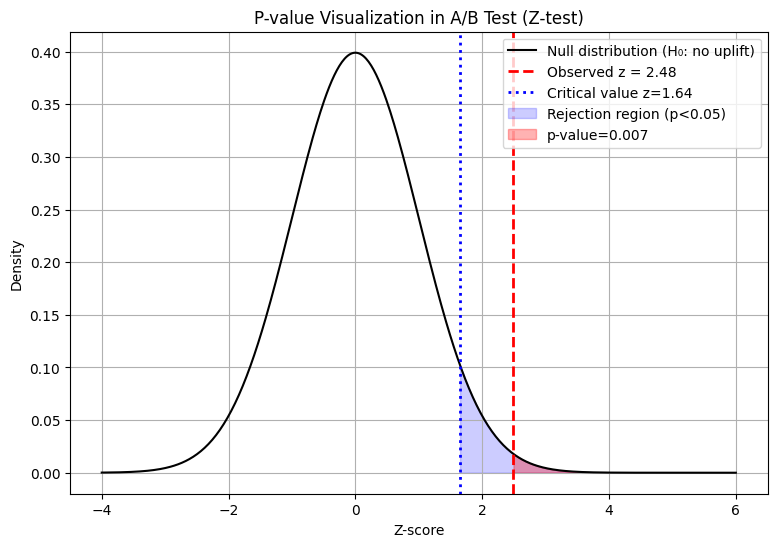

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Example: z-statistic from AB test (pooled test)
uplift = 0.02
p_A, p_B = 0.06, 0.08
n_A = n_B = 2000

# Pooled SE for hypothesis test
p_pool = (p_A*n_A + p_B*n_B) / (n_A+n_B)
SE_pooled = np.sqrt(p_pool*(1-p_pool)*(1/n_A+1/n_B))

z_stat = uplift / SE_pooled
p_value = 1 - norm.cdf(z_stat)  # one-tailed test B > A

# --------------------
# Visualization: normal curve & p-value
# --------------------
x = np.linspace(-4, 6, 500)
y = norm.pdf(x, 0, 1)

plt.figure(figsize=(9,6))
plt.plot(x, y, 'k-', label="Null distribution (H₀: no uplift)")
plt.axvline(z_stat, color='red', linestyle='--', linewidth=2, label=f"Observed z = {z_stat:.2f}")

# Shade rejection region (alpha=0.05 one-tailed)
z_alpha = norm.ppf(0.95)
plt.axvline(z_alpha, color='blue', linestyle=':', linewidth=2, label=f"Critical value z={z_alpha:.2f}")
plt.fill_between(x, 0, y, where=(x>=z_alpha), color='blue', alpha=0.2, label="Rejection region (p<0.05)")

# Shade p-value area (tail beyond observed z)
plt.fill_between(x, 0, y, where=(x>=z_stat), color='red', alpha=0.3, label=f"p-value={p_value:.3f}")

plt.title("P-value Visualization in A/B Test (Z-test)")
plt.xlabel("Z-score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

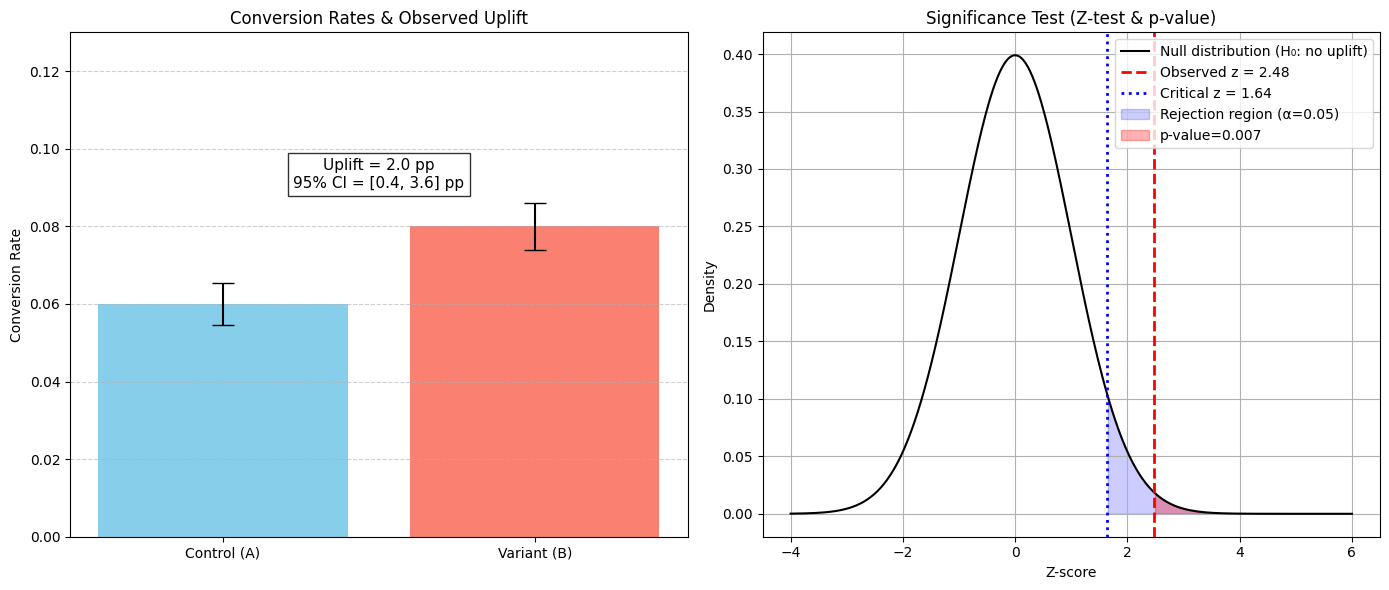

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Example data
p_A, p_B = 0.06, 0.08
n_A = n_B = 2000
uplift = p_B - p_A

# --- Standard errors ---
SE_A = np.sqrt(p_A*(1-p_A)/n_A)
SE_B = np.sqrt(p_B*(1-p_B)/n_B)
SE_diff = np.sqrt(SE_A**2 + SE_B**2)

# 95% CI for uplift
z_crit = norm.ppf(0.975)
ci_lower = uplift - z_crit*SE_diff
ci_upper = uplift + z_crit*SE_diff

# --- Hypothesis test (pooled SE) ---
p_pool = (p_A*n_A + p_B*n_B) / (n_A+n_B)
SE_pooled = np.sqrt(p_pool*(1-p_pool)*(1/n_A+1/n_B))
z_stat = uplift / SE_pooled
p_value = 1 - norm.cdf(z_stat)  # one-tailed (B > A)
z_alpha = norm.ppf(0.95)        # critical z for one-tailed alpha=0.05

# --------------------
# Visualization combined
# --------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# --- Left: Conversion rates with CI ---
groups = ['Control (A)', 'Variant (B)']
rates = [p_A, p_B]
errors = [SE_A, SE_B]

axes[0].bar(groups, rates, yerr=errors, capsize=8, color=['skyblue','salmon'])
axes[0].set_ylabel("Conversion Rate")
axes[0].set_title("Conversion Rates & Observed Uplift")
axes[0].text(0.5, max(rates)+0.01, 
             f"Uplift = {uplift*100:.1f} pp\n95% CI = [{ci_lower*100:.1f}, {ci_upper*100:.1f}] pp",
             ha='center', fontsize=11, bbox=dict(facecolor='white', alpha=0.8))
axes[0].set_ylim(0, max(rates)+0.05)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# --- Right: P-value visualization ---
x = np.linspace(-4, 6, 500)
y = norm.pdf(x, 0, 1)
axes[1].plot(x, y, 'k-', label="Null distribution (H₀: no uplift)")
axes[1].axvline(z_stat, color='red', linestyle='--', linewidth=2, label=f"Observed z = {z_stat:.2f}")
axes[1].axvline(z_alpha, color='blue', linestyle=':', linewidth=2, label=f"Critical z = {z_alpha:.2f}")
axes[1].fill_between(x, 0, y, where=(x>=z_alpha), color='blue', alpha=0.2, label="Rejection region (α=0.05)")
axes[1].fill_between(x, 0, y, where=(x>=z_stat), color='red', alpha=0.3, label=f"p-value={p_value:.3f}")
axes[1].set_title("Statistical Significance (Z-test & p-value)")
axes[1].set_xlabel("Z-score")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Other Code Examples

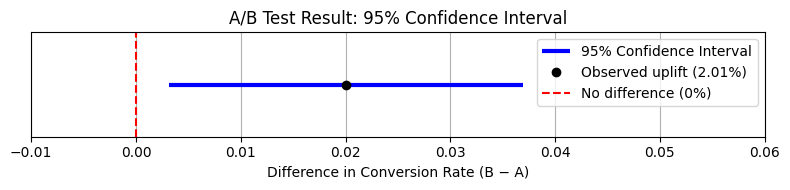

Required Sample Size per Group: 1744
Conversion Rate A (green): 0.0596
Conversion Rate B (red): 0.0797
Observed Uplift (B - A): 0.0201
Z-score: 2.33
P-value (one-tailed): 0.0099
95% Confidence Interval: [np.float64(0.0032), np.float64(0.037)]
Statistically Significant (p < α)?: True


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# baseline_rate=0.06: Expected conversion rate of the control group (e.g., 6%)
# effect_size=0.02 Minimum uplift (difference) you want to detect (e.g., +2% improvement)
# alpha=0.05: Significance level: max p-value you accept for "statistical significance" (typically 0.05)
# power=0.8:  Statistical power: probability of detecting a true effect if it exists (typically 0.80 or 80%)

# α (alpha) = probability of a Type I error
# → false positive (rejecting H₀ when it’s actually true)
# → common value: 0.05

# β (beta) = probability of a Type II error
# → false negative (failing to reject H₀ when it’s actually false)

# Power = 1 - \beta
# → probability of correctly detecting a true effect

# beta = 1 - power               # β = 0.20
# z_beta = norm.ppf(1 - beta)    # 1 - 0.20 = 0.80 → z ≈ 0.84

def run_ab_test(baseline_rate=0.06, effect_size=0.02, alpha=0.05, power=0.8):
    # Step 1: Calculate required sample size

    z_alpha = norm.ppf(1 - alpha)
    # z_alpha: z-score corresponding to the chosen significance level (α)
    # For α = 0.05, this gives z ≈ 1.645 (one-tailed), or 1.96 (two-tailed)

    z_beta = norm.ppf(power)
    # z_beta: z-score corresponding to the desired statistical power (1 - β)
    # For power = 0.80, this gives z ≈ 0.84

    pooled_prob = baseline_rate
    # pooled_prob: the expected conversion rate under the null hypothesis (i.e., in control group)

    std_dev = np.sqrt(2 * pooled_prob * (1 - pooled_prob))
    # std_dev: combined standard deviation assuming equal variances in A and B groups
    # Multiplied by 2 because we assume equal sample size and binomial distribution in both groups

    sample_size = int(np.ceil(((z_alpha + z_beta) * std_dev / effect_size) ** 2))
    # sample_size: required number of users in each group (A and B)
    # This formula estimates how many samples are needed to detect the specified effect size
    # with the chosen significance level and statistical power

    # Step 2: Simulate test results
    n_A = n_B = sample_size
    conversions_A = int(n_A * baseline_rate)
    conversions_B = int(n_B * (baseline_rate + effect_size))
    p_A = conversions_A / n_A
    p_B = conversions_B / n_B
    uplift = p_B - p_A

    # Step 3: Statistical analysis

    # SE (Standard Error) of the difference in proportions
    # This quantifies the uncertainty in the estimated difference (uplift)
    # Formula: sqrt( (p1*(1-p1)/n1) + (p2*(1-p2)/n2) )
    SE = np.sqrt((p_A * (1 - p_A)) / n_A + (p_B * (1 - p_B)) / n_B)

    # z-score: standardized value of the observed difference (uplift)
    # This tells us how many standard errors away the observed result is from "no difference"
    z = uplift / SE

    # p-value (one-tailed): probability of observing this z or greater, assuming null hypothesis is true
    # This evaluates whether the observed uplift is statistically significant
    p_value = 1 - norm.cdf(z)  # one-tailed test: testing if B > A

    # z_crit: critical z-value for a 95% confidence interval (two-tailed)
    # 0.975 corresponds to the upper 97.5% cutoff (used to capture middle 95%)
    z_crit = norm.ppf(0.975)

    # Confidence interval: range of plausible values for the true uplift
    # CI = observed uplift ± margin of error
    ci_lower = uplift - z_crit * SE
    ci_upper = uplift + z_crit * SE

    # Decision rule: is the result statistically significant?
    # If p-value < alpha (e.g. 0.05), we reject the null hypothesis
    significant = p_value < alpha

    # Step 4: Visualization
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.hlines(1, ci_lower, ci_upper, colors='blue', linewidth=3, label='95% Confidence Interval')
    ax.plot(uplift, 1, 'o', color='black', label=f'Observed uplift ({uplift*100:.2f}%)')
    ax.axvline(0, color='red', linestyle='--', label='No difference (0%)')
    ax.set_xlim(-0.01, 0.06)
    ax.set_yticks([])
    ax.set_xlabel('Difference in Conversion Rate (B − A)')
    ax.set_title('A/B Test Result: 95% Confidence Interval')
    ax.legend()
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

    # Step 5: Return results
    results = {
        "Required Sample Size per Group": sample_size,
        "Conversion Rate A (green)": round(p_A, 4),
        "Conversion Rate B (red)": round(p_B, 4),
        "Observed Uplift (B - A)": round(uplift, 4),
        "Z-score": round(z, 3),
        "P-value (one-tailed)": round(p_value, 4),
        "95% Confidence Interval": [round(ci_lower, 4), round(ci_upper, 4)],
        "Statistically Significant (p < α)?": significant
    }

    for key, value in results.items():
        print(f"{key}: {value}")

# Run the function
run_ab_test()

In [7]:
import numpy as np
from scipy.stats import norm

# --------------------------
# 1. SETUP: Input Parameters (defined BEFORE the test)
# --------------------------

# Assumptions:
baseline_rate = 0.06          # Control (green button) conversion rate
effect_size = 0.02            # Minimum uplift you care about (e.g., +2%)
alpha = 0.05                  # Significance level (one-tailed)
power = 0.8                   # Desired statistical power

# --------------------------
# 2. CALCULATE: Required Sample Size (per group)
# --------------------------

# Convert to z-scores
z_alpha = norm.ppf(1 - alpha)
z_beta = norm.ppf(power)

# Pooled standard deviation estimate
pooled_prob = baseline_rate
std_dev = np.sqrt(2 * pooled_prob * (1 - pooled_prob))

# Sample size formula for two proportions (simplified)
sample_size = ((z_alpha + z_beta) * std_dev / effect_size) ** 2
sample_size = int(np.ceil(sample_size))

# --------------------------
# 3. SIMULATE: Run A/B test with synthetic results
# --------------------------

# Let's say we run the test with this sample size
n_A = sample_size
n_B = sample_size

# Simulated outcomes
conversions_A = int(n_A * baseline_rate)
conversions_B = int(n_B * (baseline_rate + effect_size))

p_A = conversions_A / n_A
p_B = conversions_B / n_B
uplift = p_B - p_A

# --------------------------
# 4. ANALYZE: Z-score, p-value, CI
# --------------------------

# Standard error
SE = np.sqrt((p_A * (1 - p_A)) / n_A + (p_B * (1 - p_B)) / n_B)

# Z-score
z = uplift / SE

# One-tailed p-value (testing if B > A)
p_value = 1 - norm.cdf(z)

# 95% Confidence Interval
z_crit = norm.ppf(0.975)
ci_lower = uplift - z_crit * SE
ci_upper = uplift + z_crit * SE

# --------------------------
# Output
# --------------------------
results = {
    "Required Sample Size per Group": sample_size,
    "Simulated Conversion Rate A (green)": round(p_A, 4),
    "Simulated Conversion Rate B (red)": round(p_B, 4),
    "Observed Uplift (B - A)": round(uplift, 4),
    "Z-score": round(z, 3),
    "P-value (one-tailed)": round(p_value, 4),
    "95% Confidence Interval": [round(ci_lower, 4), round(ci_upper, 4)],
    "Statistically Significant (p < 0.05)?": p_value < 0.05
}

for key, value in results.items():
        print(f"{key}: {value}")

Required Sample Size per Group: 1744
Simulated Conversion Rate A (green): 0.0596
Simulated Conversion Rate B (red): 0.0797
Observed Uplift (B - A): 0.0201
Z-score: 2.33
P-value (one-tailed): 0.0099
95% Confidence Interval: [np.float64(0.0032), np.float64(0.037)]
Statistically Significant (p < 0.05)?: True
